### Kaggle Link

https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
train_df = pd.read_csv('../Data/Kaggle/toxic_train.csv')
test_df  = pd.read_csv('../Data/Kaggle/toxic_test.csv')

In [3]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### Pre-Processing

In [4]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

In [5]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
lemma = WordNetLemmatizer()

In [6]:
for df in [train_df, test_df]:
    df['comment_text'] = df['comment_text'].apply(lambda x: word_tokenize(str(x)))
    df['comment_text'] = df['comment_text'].apply(lambda x: [lemma.lemmatize(word) for word in x])
    df['comment_text'] = df['comment_text'].apply(lambda x: ' '.join(x))

### Modeling

In [7]:
cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [8]:
features = train_df.columns.difference(cols)
train_df["comment_text"].fillna(" ", inplace=True)
test_df["comment_text"].fillna(" ", inplace=True)

x_train = train_df[features].drop('id', axis=1)
x_test  = test_df[features].drop('id', axis=1)
y_train = train_df[cols]

In [9]:
x_train.head()

,comment_text
0,Explanation Why the edits made under my userna...
1,D'aww ! He match this background colour I 'm s...
2,"Hey man , I 'm really not trying to edit war ...."
3,`` More I ca n't make any real suggestion on i...
4,"You , sir , are my hero . Any chance you remem..."


In [10]:
y_train.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


#### TfidfVectorizer + Logistic Regression

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [12]:
vect_word = TfidfVectorizer(lowercase=True, analyzer='word', token_pattern=r'\w{1,}', strip_accents='unicode',
                            ngram_range=(1, 1), sublinear_tf=True, max_features=20000)
vect_char = TfidfVectorizer(lowercase=True, analyzer='char', strip_accents='unicode',
                            ngram_range=(1, 1), sublinear_tf=True, max_features=30000)

X_train_vectorized_word = vect_word.fit_transform(x_train['comment_text'])
X_train_vectorized_char = vect_char.fit_transform(x_train['comment_text'])

X_test_vectorized_word = vect_word.transform(x_test['comment_text'])
X_test_vectorized_char = vect_char.transform(x_test['comment_text'])

C:\Users\paula.ceccon.ribeiro\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [13]:
print('Vocabulary len:', len(vect_word.get_feature_names()))
print('Longest word:', len(max(vect_word.vocabulary_, key=len)))

Vocabulary len: 20000
Longest word: 173


In [14]:
print('Vocabulary len:', len(vect_char.get_feature_names()))
print('Longest word:', len(max(vect_char.vocabulary_, key=len)))

Vocabulary len: 1696
Longest word: 1


In [15]:
from scipy import sparse

In [16]:
X_train_vectorized = sparse.hstack([X_train_vectorized_word, X_train_vectorized_char])
X_test_vectorized  = sparse.hstack([X_test_vectorized_word, X_test_vectorized_char])

In [17]:
X_train_vectorized.shape

(159571, 21696)

In [18]:
X_test_vectorized.shape

(153164, 21696)

In [19]:
from sklearn.linear_model import LogisticRegression

In [20]:
from sklearn.metrics import roc_auc_score

In [21]:
y_pred = np.zeros((test_df.shape[0], len(cols)))

roc_auc = []
for i, j in enumerate(cols):
    model = LogisticRegression(C=4, n_jobs=-1)
    model.fit(X_train_vectorized, y_train[j])
    y_pred[:,i] = model.predict_proba(X_test_vectorized)[:,1]
    y_check = model.predict_proba(X_train_vectorized)[:,1]
    roc_auc.append(roc_auc_score(y_train[j], y_check))
    
np.mean(roc_auc)

C:\Users\paula.ceccon.ribeiro\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


0.9950680735141543

In [22]:
y_df = pd.DataFrame(y_pred, columns=cols)
submission = pd.concat([test_df['id'], y_df], axis=1)
submission.to_csv('tfidf-logistic.csv', index=False)

Score: 0.9756

#### Deep Learning

In [11]:
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, Input, Activation
from keras.layers import LSTM, Bidirectional, Flatten, GlobalMaxPool1D, Dropout, SpatialDropout1D, GRU, Conv1D
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, Callback
from keras.layers.normalization import BatchNormalization
import keras.backend as K

C:\Users\paula.ceccon.ribeiro\AppData\Local\Continuum\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [12]:
from IPython.display import clear_output

class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.figure(figsize=(10, 5))
        plt.plot(self.x, self.losses, label='loss')
        plt.plot(self.x, self.val_losses, label='val_loss')
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [13]:
x_train['comment_text'].str.len().mean()

402.2861798196414

In [14]:
x_test['comment_text'].str.len().mean()

370.91567861899665

In [15]:
max_features = 50000
maxlen = 300

In [16]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(x_train['comment_text']))

X_train = tokenizer.texts_to_sequences(x_train['comment_text'])
X_test  = tokenizer.texts_to_sequences(x_test['comment_text'])
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test  = sequence.pad_sequences(X_test,  maxlen=maxlen)

In [17]:
import gc

In [18]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
epochs = 20

##### LSTM

In [31]:
def get_model():
    model = Sequential()
    model.add(Embedding(max_features, 64, input_length=maxlen))
    model.add(SpatialDropout1D(0.3))
    model.add(LSTM(256, dropout=0.3, recurrent_dropout=0.3))

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(6))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [32]:
for i in range(10):
    gc.collect()
    K.clear_session()

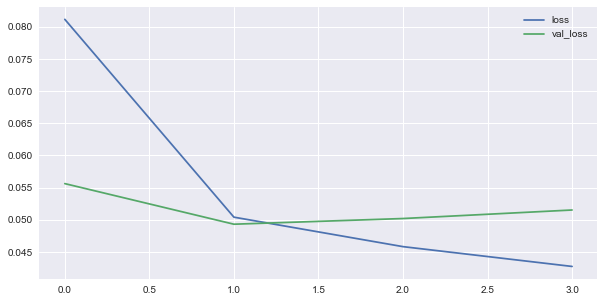

 - 1718s - loss: 0.0427 - acc: 0.9837 - val_loss: 0.0515 - val_acc: 0.9822


In [33]:
model = get_model()
model.fit(X_train, y_train.values, epochs=epochs, verbose=2, validation_split=0.3, callbacks=[plot_losses, early_stopping])

In [34]:
y_pred = model.predict(X_test)

In [36]:
y_df = pd.DataFrame(y_pred, columns=cols)
submission = pd.concat([test_df['id'], y_df], axis=1)
submission.to_csv('lstm.csv', index=False)

Score: 0.9666

##### Bidirectional LSTM

In [37]:
def get_model():
    model = Sequential()
    model.add(Embedding(max_features, 64, input_length=maxlen))
    model.add(SpatialDropout1D(0.3))
    model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(6))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [38]:
for i in range(10):
    gc.collect()
    K.clear_session()

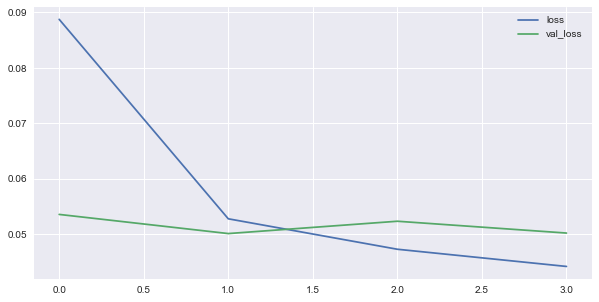

 - 3823s - loss: 0.0441 - acc: 0.9833 - val_loss: 0.0502 - val_acc: 0.9818


In [39]:
model = get_model()
model.fit(X_train, y_train.values, epochs=epochs, verbose=2, validation_split=0.3, callbacks=[plot_losses, early_stopping])

In [40]:
y_pred = model.predict(X_test)

In [41]:
y_df = pd.DataFrame(y_pred, columns=cols)
submission = pd.concat([test_df['id'], y_df], axis=1)
submission.to_csv('bid-lstm.csv', index=False)

Score: 0.9645

##### GRU

In [42]:
def get_model():
    model = Sequential()
    model.add(Embedding(max_features, 64, input_length=maxlen))
    model.add(SpatialDropout1D(0.3))
    model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
    model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3))

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(6))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [43]:
for i in range(10):
    gc.collect()
    K.clear_session()

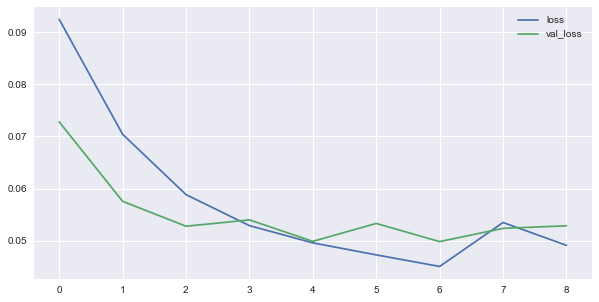

 - 3085s - loss: 0.0491 - acc: 0.9820 - val_loss: 0.0528 - val_acc: 0.9812


In [44]:
model = get_model()
model.fit(X_train, y_train.values, epochs=epochs, verbose=2, validation_split=0.3, callbacks=[plot_losses, early_stopping])

In [45]:
y_pred = model.predict(X_test)

In [47]:
y_df = pd.DataFrame(y_pred, columns=cols)
submission = pd.concat([test_df['id'], y_df], axis=1)
submission.to_csv('gru.csv', index=False)

Score: 0.09557

##### 1D Convolution

In [19]:
def get_model():
    model = Sequential()
    model.add(Embedding(max_features, 64, input_length=maxlen))
    model.add(SpatialDropout1D(0.3))
    model.add(Conv1D(256, 5, padding='valid', activation='relu', strides=1))
    model.add(GlobalMaxPool1D())

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(6))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [20]:
for i in range(10):
    gc.collect()
    K.clear_session()

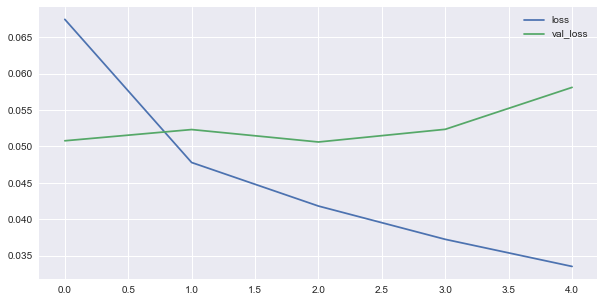

 - 107s - loss: 0.0335 - acc: 0.9866 - val_loss: 0.0581 - val_acc: 0.9813


In [21]:
model = get_model()
model.fit(X_train, y_train.values, epochs=epochs, verbose=2, validation_split=0.3, callbacks=[plot_losses, early_stopping])

In [22]:
y_pred = model.predict(X_test)

In [23]:
y_df = pd.DataFrame(y_pred, columns=cols)
submission = pd.concat([test_df['id'], y_df], axis=1)
submission.to_csv('conv1d.csv', index=False)

Score: 0.9694